In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [60]:
import warnings
warnings.simplefilter('ignore')

**Содержание**
    * [1. Анализ данных и проверка гипотез](#analysis)

# <left>1. Анализ данных и проверка гипотез<a class="anchor" id="analysis"></a><left>

In [2]:
train_df = pd.read_csv('train.csv', encoding='utf-8')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [3]:
test_df = pd.read_csv('test.csv', encoding='utf-8')

In [6]:
train_df.shape

(7500, 17)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

## 1.1. Глобальные переменные

Список категориальных переменных.

In [39]:
cat_features = [col for col in train_df.columns if train_df[col].dtype == 'object']

Список непрерывных переменных.

In [44]:
nom_features = [col for col in train_df.columns if train_df[col].dtype == 'float64']

## 1.2. Используемые функции

График оценки статистической частоты.

In [20]:
def estimate_frequency_plot(data, variables, font_scale, figsize, style):
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    plt.style.use(style)

    for i, feature in enumerate(variables):
        counts = data[feature].value_counts()

        plt.subplot(3,2,i+1)    
        plt.title(feature)
        sns.barplot(counts.index, counts.values)

График оценки доли переменной в разрезе целевой переменной.

In [163]:
def estimate_share_plot(data, variables, font_scale, figsize, style, hue):
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    plt.style.use(style)

    for i, feature in enumerate(variables):

        plt.subplot(3,2,i+1)
        plt.title(feature)
        sns.countplot(x=feature, hue=hue, data=data)

График доверительного интервала с расчётом.

In [173]:
def confidence_interval_plot(data, variables, font_scale, figsize, style, capsize, target):
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    plt.style.use(style)
    
    for i, feature in enumerate(variables):
       
        plt.subplot(4,3,i+1)  
        sns.pointplot(x=target, y=feature, data=data, capsize=capsize)
        plt.title('95 процентный доверительный интервал для' + ' ' + feature);

График оценки распределения.

In [189]:
def qq_plot(data, variables, figsize):
    plt.figure(figsize=figsize)
    
    for i, feature in enumerate(variables):
        
        plt.subplot(4,3,i+1)
        probplot(data[feature], dist='norm', plot=plt);
        plt.title('Распределение' + ' ' + feature);

Расчёт критерия согласия Хи-квадрат Пирсона.

In [205]:
def calc_chi2(data, target, values, feature, category1, category2, aggfunc, treshold):
    table = data.loc[data[feature].isin([category1, category2]),[values, feature, target]]
    table[values] = table.index
    chi2_table = table.pivot_table(values = values,
                                   index=feature, 
                                   columns=target, 
                                   aggfunc=aggfunc)
    chi2, p, dof, expected = chi2_contingency(chi2_table, correction=False)
    
    if p < treshhold:
        print(f'Разделение на категории {category1} и {category2} для {feature} статистически значимо')
    else:
        print(f'Разделение на категории {category1} и {category2} для {feature} статистически незначимо')

Расчёт критерия Шапиро-Уилка.

In [281]:
def calc_shapiro(data, variables, treshold, target):
    for feature in data[variables]:
        feature_with_target = data[[feature, target]]
        feature_ = feature_with_target[feature]
        stat, p = shapiro(data[feature_])
        
        if p < treshold:
            print(f'Гипотеза о нормальном распределении для {feature} отвергается')
        else:
            print(f'Гипотеза о нормальном распределении для {feature} принимается')

Проверка гипотез о зависимости признаков с целевой переменной.

In [283]:
def dependency_hypo(data, variables, treshold, target):
    
    for feature in data[variables]:
        feature_with_target = data[[feature,target]]
        feature = feature_with_target[feature]
        stat, p = shapiro(data[feature])
    
        feature_0 = feature_[feature_with_target[target] == 0]
        feature_1 = feature_[feature_with_target[target] == 1]
        
        if p < treshold:
            stat, p_= mannwhitneyu(feature_0, feature_1)

            if p_< treshold:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} отвергается')
            else:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} принимается')
                  
        else:
            stat, p_= ttest_ind(feature_0, feature_1)

            if p_< treshold:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} отвергается')
            else:
                print(f'Гипотеза о равенстве мат.ожиданий для {feature} принимается')

График для оценки корреляций.

In [47]:
def cor_plot(data, method):
    plt.figure(figsize = (14,14))

    sns.set(font_scale=1)
    sns.heatmap(data.corr(method).round(2), annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Матрица корреляций');

## 1.3. Анализ категориальных признаков

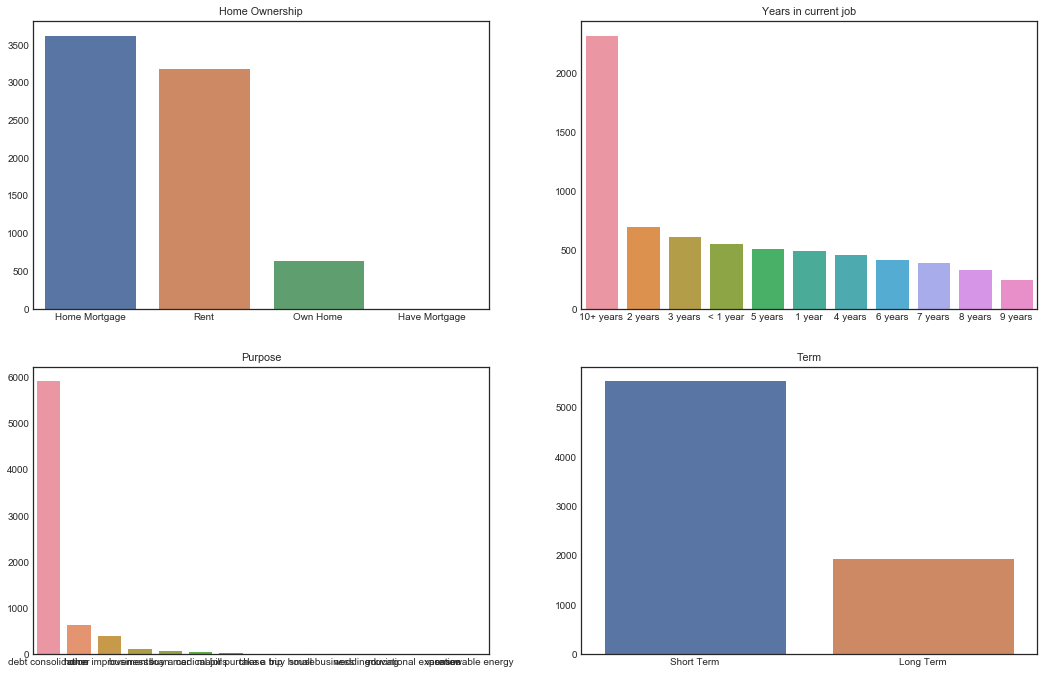

In [161]:
estimate_frequency_plot(train_df, cat_features, 0.9, (18,18), 'seaborn-white')

Кроме переменной "срок кредита", категорий довольно много. Для всех переменных характерен дисбаланс категорий,
т.е. одни категории встречаются очень часто, а другие - довольно редко. Проведу оценку этих признаков в разрезе целевой переменной, чтобы понять оптимальное количество групп, на которые стоит разбивать эти признаки. Для этого буду использовать 
критерий хи-квадрат Пирсона на уровне значимости 0.05.

Метод позволяет оценить статистическую значимость различий двух или нескольких относительных показателей (частот, долей).

$x^n = (x_1, .. , x_n), \: x^n \in X$<br>

$H_0:$ Эмпирические (наблюдаемые) и теоретические (ожидаемые) частоты согласованы <br>
$H_1: \: H_0 \:$ неверна<br>

$$\chi^2 = \sum_{i=1}^K \frac{(O_i - E_i)^2}{E_i}$$
$O$ (Observed) - наблюдаемые частоты<br> 
$E$ (Expected) - ожидаемые частоты<br>
$K$ - количество оцениваемых частот

$\chi^2 \sim \chi^2(\mathit{df})$

Сопоставляемые группы должны быть независимыми, то есть критерий хи-квадрат не должен применяться при сравнении наблюдений "до-после" или связанных пар. Аналог для зависимых выборок - *тест Мак-Немара* или *Q-критерий Кохрена* для сравнения трех и более групп.

Если в ячейке меньше 10 наблюдений, применяется *поправка Йетса*. 

Если меньше 5, то вместо хи-квадрат используется *точный тест Фишера*.

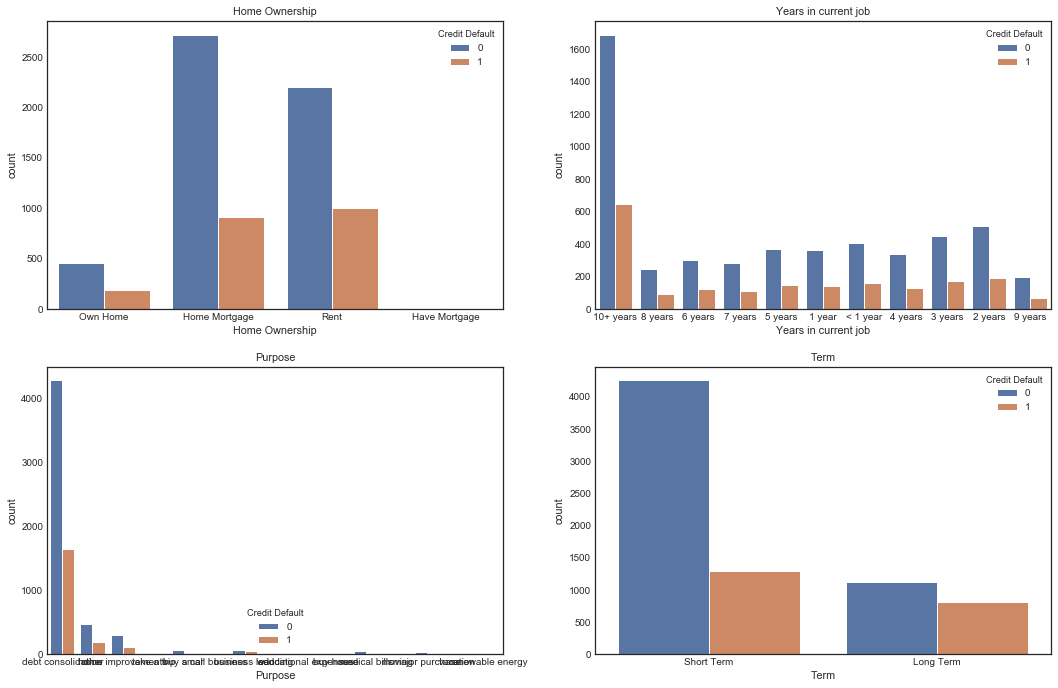

In [164]:
estimate_share_plot(train_df, cat_features, 0.9, (18,18), 'seaborn-white', 'Credit Default')

Визуальная оценка графиков позволяет сделать следующие гипотезы.

Для переменной **Home Ownership** доля целевого признака во всех категориях примерно одинакова. Такая же картина
наблюдается для переменной **Years in current job**, а также для переменной **Purpose**. Для переменной **Term** доля целевой переменной в категориях не одинакова. Теперь проверю эти гипотезы, используя расчётный тест.

In [130]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Home Ownership', category1='Own Home', 
          category2='Rent', aggfunc='count')

'Разделение на категории Own Home и Rent для Home Ownership статистически незначимо'

In [136]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Home Ownership', category1='Rent', 
          category2='Home Mortrage', aggfunc='count')

'Разделение на категории Rent и Home Mortrage для Home Ownership статистически незначимо'

In [137]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Years in current job', category1='10+ years', 
          category2='1 year', aggfunc='count')

'Разделение на категории 10+ years и 1 year для Years in current job статистически незначимо'

In [144]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Purpose', category1='debt consolidation', 
          category2='home improvements', aggfunc='count')

'Разделение на категории debt consolidation и home improvements для Purpose статистически незначимо'

In [131]:
calc_chi2(data=train_df, target='Credit Default', values='id',
          feature='Term', category1='Short Term', 
          category2='Long Term', aggfunc='count')

'Разделение на категории Short Term и Long Term для Term статистически значимо'

Расчётные значения подтвердили гипотезы. На уровне значимости 0.05 у нас нет оснований отвергать нулевую гипотезу только для переменной **Short Term**. Только для срока кредита разбиение на категории статистически значимо.

В остальных переменных оставлю только одну категорию

*   **Is_home_ownership** - наличие права собственности на жилую площадь
*   **Is_stable_employment** - заёмщик на текущем месте работы более 10 лет
*   **Is_debt_consolidation** - кредит берётся на покрытие другого кредита
*   **Is_longterm_credit** - кредит береётся на длительный срок

In [5]:
train_df.rename(columns={'Home Ownership': 'Is_home_ownership',
               'Years in current job': 'Is_stable_employment',
               'Purpose': 'Is_debt_consolidation'}, 
               inplace=True)

In [7]:
test_df.rename(columns={'Home Ownership': 'Is_home_ownership',
               'Years in current job': 'Is_stable_employment',
               'Purpose': 'Is_debt_consolidation'}, 
               inplace=True)

In [8]:
to_preprocess = ['Is_home_ownership', 'Is_stable_employment', 'Is_debt_consolidation']

In [11]:
train_df['Is_home_ownership'] = train_df['Is_home_ownership'].replace({'Home Mortgage': 1, 'Own Home': 1, 
                                                                     'Have Mortgage': 1, 'Rent': 0})
test_df['Is_home_ownership'] = test_df['Is_home_ownership'].replace({'Home Mortgage': 1, 'Own Home': 1, 
                                                                     'Have Mortgage': 1, 'Rent': 0})

In [13]:
train_df['Is_stable_employment'] = train_df['Is_stable_employment'].replace({'2 years': 1, '3 years': 1, '< 1 year': 1,
                                                                            '5 years': 1, '1 year': 1, '4 years': 1,
                                                                            '6 years': 1, '7 years': 1, '8 years': 1,
                                                                            '9 years': 1, '10+ years': 0})
test_df['Is_stable_employment'] = test_df['Is_stable_employment'].replace({'2 years': 1, '3 years': 1, '< 1 year': 1,
                                                                            '5 years': 1, '1 year': 1, '4 years': 1,
                                                                            '6 years': 1, '7 years': 1, '8 years': 1,
                                                                            '9 years': 1, '10+ years': 0})

In [15]:
train_df['Is_debt_consolidation'] = train_df['Is_debt_consolidation'].replace({'other': 1, 'home improvements': 1, 
                                                                              'business loan': 1, 'buy a car': 1,
                                                                              'medical bills': 1, 'major purchase': 1,
                                                                              'take a trip': 1, 'buy house': 1,
                                                                              'small business': 1, 'wedding': 1,
                                                                              'moving': 1, 'educational expenses': 1,
                                                                              'vacation': 1, 'renewable energy': 1,
                                                                              'debt consolidation': 0})
test_df['Is_debt_consolidation'] = test_df['Is_debt_consolidation'].replace({'other': 1, 'home improvements': 1, 
                                                                              'business loan': 1, 'buy a car': 1,
                                                                              'medical bills': 1, 'major purchase': 1,
                                                                              'take a trip': 1, 'buy house': 1,
                                                                              'small business': 1, 'wedding': 1,
                                                                              'moving': 1, 'educational expenses': 1,
                                                                              'vacation': 1, 'renewable energy': 1,
                                                                              'debt consolidation': 0})

In [24]:
train_df.rename(columns={'Term': 'Is_longterm_credit'}, 
               inplace=True)
test_df.rename(columns={'Term': 'Is_longterm_credit'}, 
               inplace=True)

In [25]:
train_df['Is_longterm_credit'] = train_df['Is_longterm_credit'].replace({'Short Term': 1, 'Long Term': 0})
test_df['Is_longterm_credit'] = test_df['Is_longterm_credit'].replace({'Short Term': 1, 'Long Term': 0})

In [34]:
train_df['Is_home_ownership'] = train_df['Is_home_ownership'].astype('str')
train_df['Is_stable_employment'] = train_df['Is_stable_employment'].astype('str')
train_df['Is_debt_consolidation'] = train_df['Is_debt_consolidation'].astype('str')
train_df['Is_longterm_credit'] = train_df['Is_longterm_credit'].astype('str')

In [36]:
test_df['Is_home_ownership'] = test_df['Is_home_ownership'].astype('str')
test_df['Is_stable_employment'] = test_df['Is_stable_employment'].astype('str')
test_df['Is_debt_consolidation'] = test_df['Is_debt_consolidation'].astype('str')
test_df['Is_longterm_credit'] = test_df['Is_longterm_credit'].astype('str')

In [ ]:
train_df['Is_stable_employment'].astype('str')
train_df['Is_debt_consolidation'].astype('str')

## 1.4. Анализ непрерывных признаков

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их.

Доверительный интервал - это вид интервальной оценки, которая задаёт числовые границы, в которых с определённой вероятностью находится истинное значение оцениваемого параметра.

**Порядок расчета доверительного интервала (для мат. ожидания)**

1. Задать уровень достоверности (confidence level), $\alpha = 95\% = 0.95$
2. Найти по таблице Z-оценок или рассчитать коэффициент достоверности (confidence coefficient) - $ Z_{\alpha/2}$, для $\alpha = 0.95, Z_{\alpha/2} = 1.96$
3. Рассчитать доверительный интервал (confidence interval):

$$ CI = \overline{x} \pm Z_{\alpha/2} \frac{\sigma}{\sqrt{n}}$$<br>
где $ \bar{x}$ - выборочное среднее, $ \sigma$ - стандартное отклонение, $ n$ - размер выборки

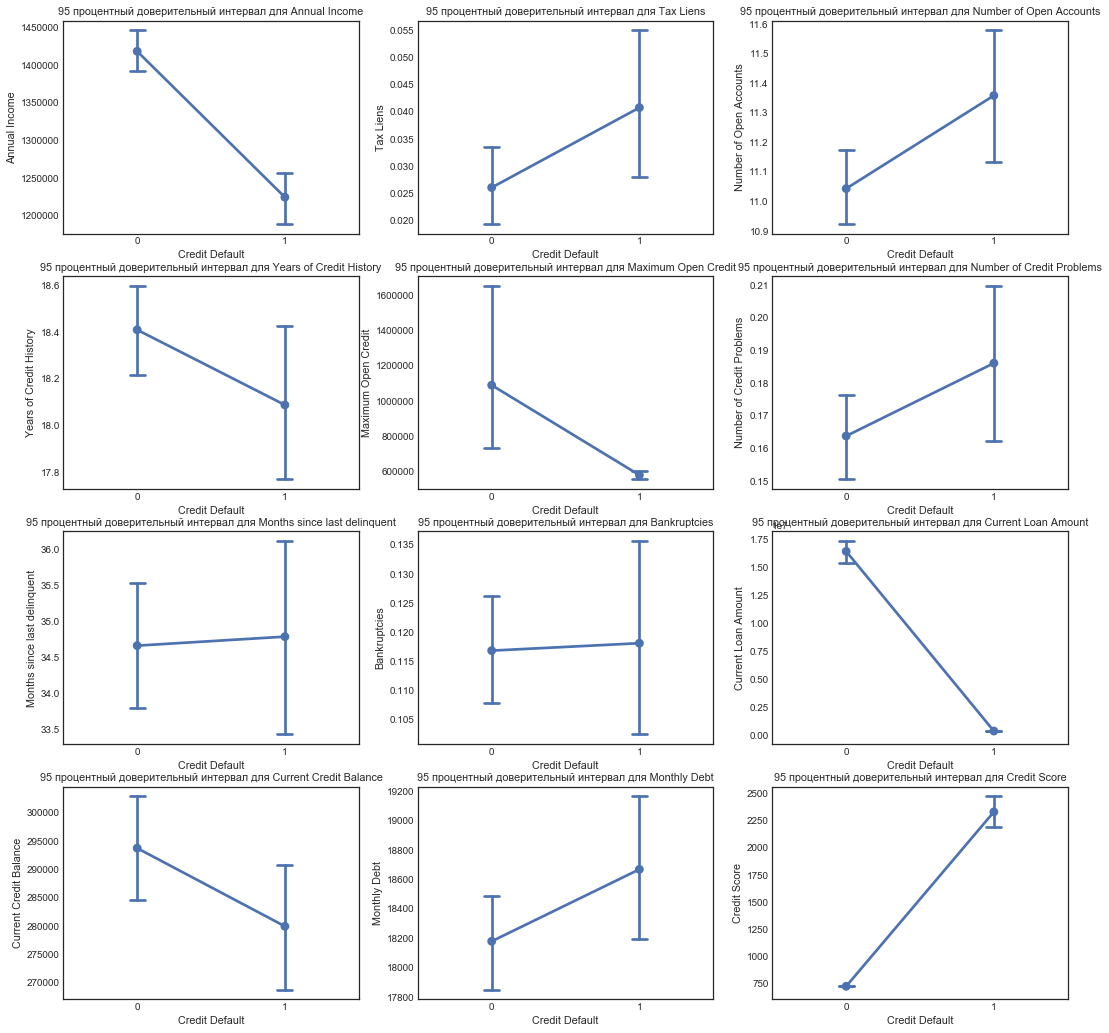

In [174]:
confidence_interval_plot(data=train_df, variables=nom_features, 
                         font_scale=0.9, figsize=(18,18), 
                         style='seaborn-white', capsize=.1,
                         target='Credit Default');

На 95 процентном доврительном интервале средние значения для переменных **Months since last delinquent** и **Bankruptcies** 
практически одинаково. Для остальных непрерывных признаков выборочные средние различаются. Это может говорить о том, что
эти две переменные **не оказывают функциональной зависимости на целевую переменную**. Проверим эту гипотезу при помощи анализа
распределений.

Оценим распределение визуально при помощи qq-plot.

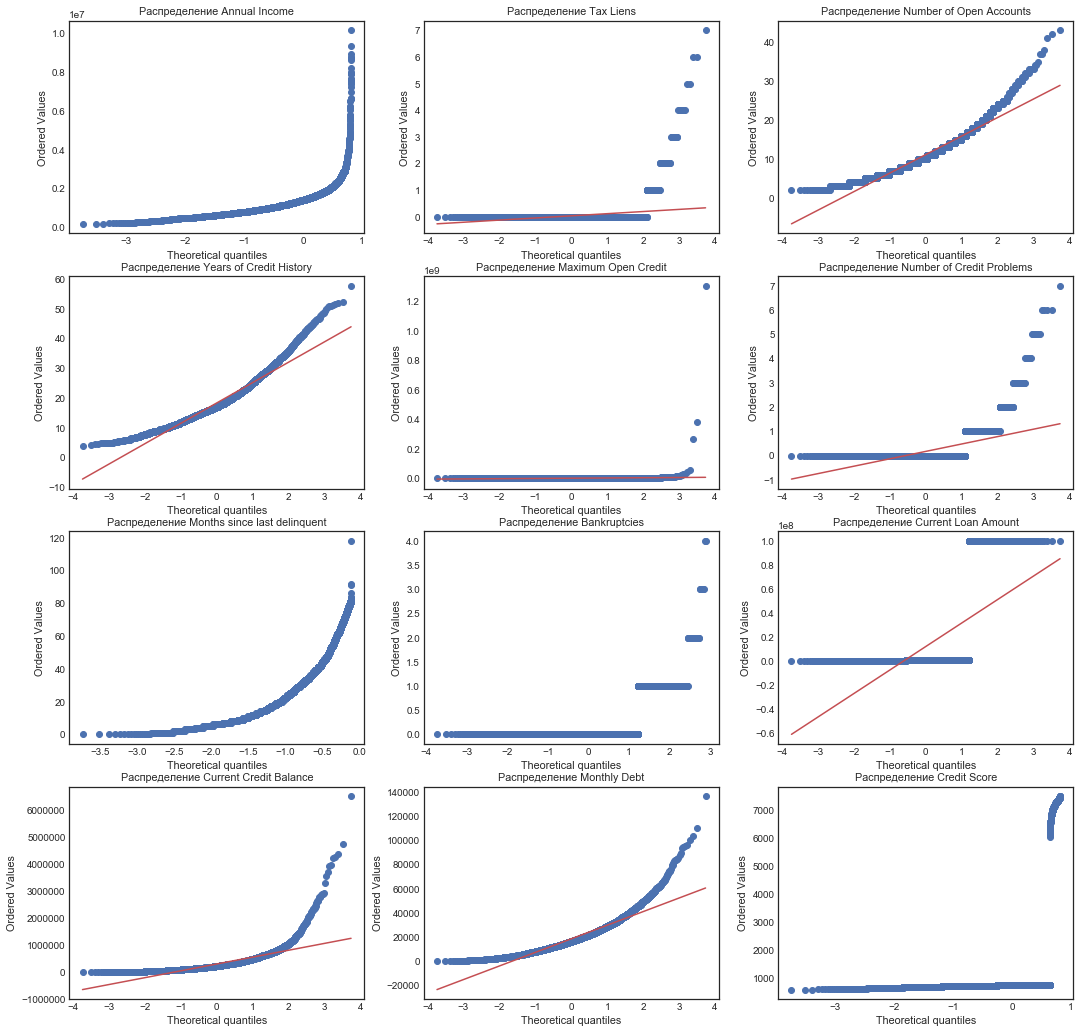

In [190]:
qq_plot(train_df, nom_features, figsize=(18,18))

Проверю гипотезу о нормальном распределении при помощи критерия Шапиро-Уилка.

Данный критерий проверяет гипотезу о том, что некоторая случайная величина имеет нормальное распределение (распределение Гаусса). Необходимость проверять случайную величину на "нормальность", обусловлена тем, что многие статистические критерии и  аналитические методы из мат. статистики ориентированы на выборки из нормально распределённых случайных величин и перед их использованием необходимо убедиться в том, что закон распределения приближен к нормальному.

$x^n = (x_1, .. , x_n), \: x^n \in X$<br>

$H_0: \: X \sim N(\mu, \sigma^2)$<br>
$H_1: \: H_0 \: неверна$<br>

$$W = \frac{(\sum_{i=1}^n a_i x_i)^2}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

In [282]:
calc_shapiro(data=train_df, variables=nom_features, 
             treshold=0.05, target='Credit Default')

KeyError: "None of [Float64Index([ 482087.0, 1025487.0,  751412.0,  805068.0,  776264.0,       nan,\n              1511108.0, 1040060.0,       nan,       nan,\n              ...\n              1368000.0, 2833185.0,       nan, 1257610.0,       nan,  402192.0,\n              1533984.0, 1878910.0,       nan,       nan],\n             dtype='float64', length=7500)] are in the [columns]"

Проведу оценку возможной функциональной зависимости при помощи t-критерия Стьюдента для признаков с нормальным распредлением и критерий Манна-Уитни для признаков с распределением, отличного от нормального.

Критерий Стьюдента* — общее название для статистических тестов, в которых статистика критерия имеет распределение Стьюдента.<br> Наиболее часто данные критерии применяются для проверки равенства средних значений (мат. ожиданий) в двух выборках.

$ x_1^{n_1} = (x_{11}, .. , x_{1{n_1}}), \: x_1^{n_1} \in X_1, \: X_1 \sim \mathrm{N}(\mu_1, \sigma_1^2), \sigma_1 неизвестна$<br>
$ x_2^{n_2} = (x_{21}, .. , x_{2{n_2}}), \: x_2^{n_2} \in X_2, \: X_2 \sim \mathrm{N}(\mu_2, \sigma_2^2), \sigma_2 неизвестна$<br>

$H_0: \: \mu_1 = \mu_2$<br>
$H_1: \: \mu_1 \ne \mu_2\text{ либо }\mu_1 < \mu_2\text{ либо }\mu_1 > \mu_2$<br>

$$T(x_1^{n_1}, x_2^{n_2}) = \frac{\overline{x_1} \: - \: \overline{x_2}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}$$
$T(x_1^{n_1}, x_2^{n_2}) \sim \mathrm{t }(\mathit{df}=n_1+n_2-2)$

In [269]:
dependency_hypo(data=train_df, variables=nom_features, treshold=0.05, target='Credit Default')

KeyError: "None of [Float64Index([ 482087.0, 1025487.0,  751412.0,  805068.0,  776264.0,       nan,\n              1511108.0, 1040060.0,       nan,       nan,\n              ...\n              1368000.0, 2833185.0,       nan, 1257610.0,       nan,  402192.0,\n              1533984.0, 1878910.0,       nan,       nan],\n             dtype='float64', length=7500)] are in the [columns]"

## 1.5. Анализ признакового пространства

Проверим наличие мультиколлинеарности при помощи корреляции Пирсона для непрерывных признаков и корреляции Спирмэна для
категориальных признаков.

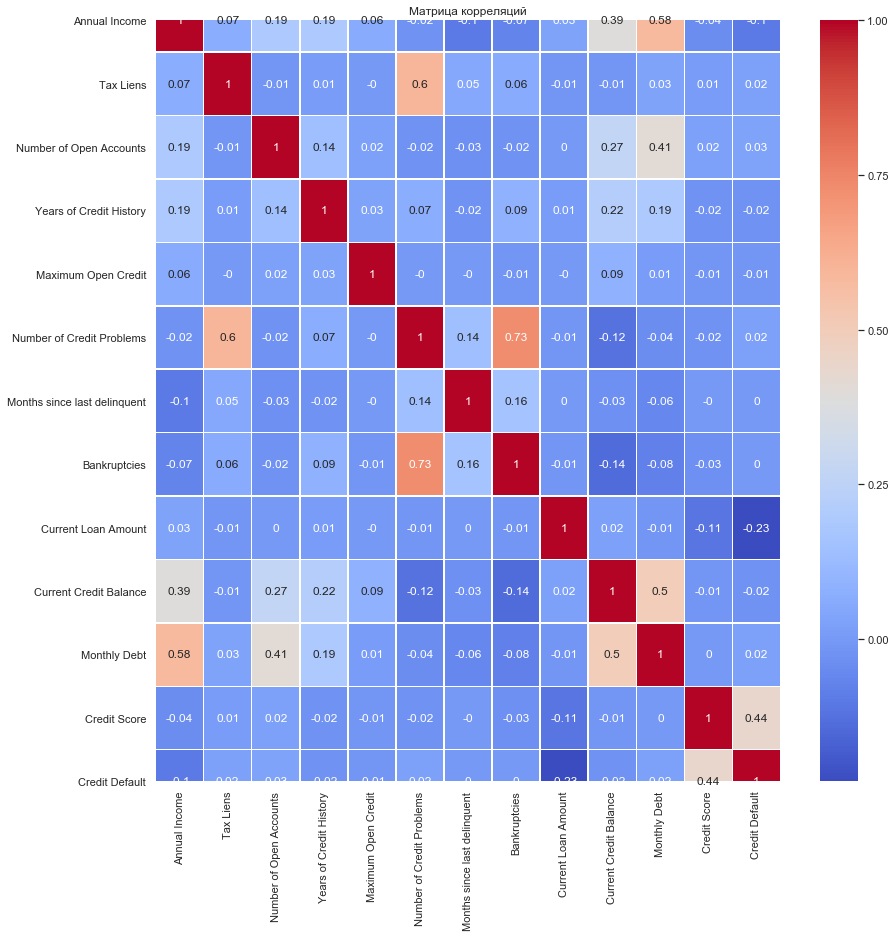

In [49]:
cor_plot(data=train_df, method='pearson');

Признаки практически не имеют линейной зависимости друг с другом, наблюдается частичная мультиколлинеарность. Имеющиеся признаки довольно уникальны.

In [52]:
train_df.to_csv('train_processed.csv', encoding='utf-8', index=False)
test_df.to_csv('test_processed.csv', encoding='utf-8', index=False)

## 1.6. Анализ целевой переменной

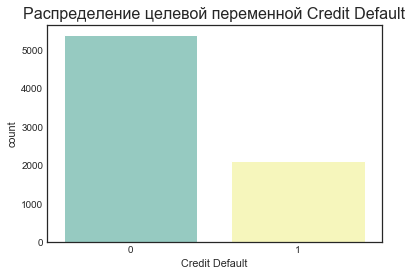

In [230]:
sns.countplot(x='Credit Default', data = train_df, palette="Set3")
plt.title('Распределение целевой переменной Credit Default', fontsize=16);

Классы не сбалансированы.